In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
from torch.optim.lr_scheduler import ReduceLROnPlateau

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import os
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print("PyTorch Version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())

IMG_HEIGHT = 96
IMG_WIDTH = 96
IMG_CHANNELS = 1
NUM_CLASSES = 7
BATCH_SIZE = 16
EPOCHS = 50
LEARNING_RATE = 0.0001

EMOTION_LABELS = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

PyTorch Version: 2.7.1+cu118
CUDA Available: True
Using device: cuda


In [ ]:
def get_data_transforms():
    train_transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
        transforms.RandomRotation(5),  
        transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),  
        transforms.RandomHorizontalFlip(p=0.3),  
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229]) 
    ])
    
    val_transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229])
    ])
    
    return train_transform, val_transform


def create_data_loaders(train_dir, val_dir, test_dir=None):
    train_transform, val_transform = get_data_transforms()    
    train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)  
    val_dataset = datasets.ImageFolder(val_dir, transform=val_transform)
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )
    
    test_loader = None
    if test_dir and os.path.exists(test_dir):
        test_dataset = datasets.ImageFolder(test_dir, transform=val_transform)
        test_loader = DataLoader(
            test_dataset,
            batch_size=BATCH_SIZE,
            shuffle=False,
            num_workers=4,
            pin_memory=True
        )
    
    return train_loader, val_loader, test_loader, train_dataset.classes

In [ ]:
class EmotionCNN(nn.Module):    
    def __init__(self, num_classes=NUM_CLASSES):
        super(EmotionCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout2d(0.25)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout2d(0.25)
        
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout2d(0.3)
        
        self.conv7 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn7 = nn.BatchNorm2d(256)
        self.conv8 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn8 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout4 = nn.Dropout2d(0.3)
        
        self.conv9 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.bn9 = nn.BatchNorm2d(128)
        self.conv10 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.bn10 = nn.BatchNorm2d(64)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout5 = nn.Dropout2d(0.4)
        
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.fc1 = nn.Linear(64, 128)
        self.dropout6 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 64)
        self.dropout7 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(64, num_classes)
        
        self._initialize_weights()
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)
        
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        x = self.dropout3(x)
        
        x = F.relu(self.bn7(self.conv7(x)))
        x = F.relu(self.bn8(self.conv8(x)))
        x = self.pool4(x)
        x = self.dropout4(x)
        
        x = F.relu(self.bn9(self.conv9(x)))
        x = F.relu(self.bn10(self.conv10(x)))
        x = self.pool5(x)
        x = self.dropout5(x)
        
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout6(x)
        x = F.relu(self.fc2(x))
        x = self.dropout7(x)
        x = self.fc3(x)
        
        return x
    
def create_model(num_classes = NUM_CLASSES):
    return EmotionCNN(num_classes=num_classes)


In [9]:
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, num_classes, smoothing=0.1, temperature=1.0):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.num_classes = num_classes
        self.smoothing = smoothing
        self.temperature = temperature
        self.confidence = 1.0 - smoothing
        
    def forward(self, predictions, targets):
        batch_size = predictions.size(0)
        
        predictions = predictions / self.temperature
        
        true_dist = torch.zeros_like(predictions)
        true_dist.fill_(self.smoothing / (self.num_classes - 1))
        true_dist.scatter_(1, targets.unsqueeze(1), self.confidence)
        
        log_probs = F.log_softmax(predictions, dim=1)
        loss = -torch.sum(true_dist * log_probs) / batch_size
        
        return loss

In [10]:
class AdaptiveLabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, num_classes, base_smoothing=0.1, temperature=1.0):
        super(AdaptiveLabelSmoothingCrossEntropy, self).__init__()
        self.num_classes = num_classes
        self.base_smoothing = base_smoothing
        self.temperature = temperature
        
        self.emotion_similarity = self._create_emotion_similarity_matrix()
        
    def _create_emotion_similarity_matrix(self):
        if self.num_classes == 7:
            similarity = torch.tensor([
                [1.0, 0.3, 0.2, 0.0, 0.4, 0.1, 0.2],
                [0.3, 1.0, 0.3, 0.0, 0.2, 0.1, 0.2],
                [0.2, 0.3, 1.0, 0.0, 0.5, 0.4, 0.3],
                [0.0, 0.0, 0.0, 1.0, 0.0, 0.3, 0.2],
                [0.4, 0.2, 0.5, 0.0, 1.0, 0.1, 0.4],
                [0.1, 0.1, 0.4, 0.3, 0.1, 1.0, 0.2],
                [0.2, 0.2, 0.3, 0.2, 0.4, 0.2, 1.0]
            ], dtype=torch.float32)
        else:
            similarity = torch.eye(self.num_classes) + 0.1 * (1 - torch.eye(self.num_classes))
        
        similarity = similarity / similarity.sum(dim=1, keepdim=True)
        return similarity
    
    def forward(self, predictions, targets):
        device = predictions.device
        batch_size = predictions.size(0)
        
        predictions = predictions / self.temperature
        
        if self.emotion_similarity.device != device:
            self.emotion_similarity = self.emotion_similarity.to(device)
        
        true_dist = torch.zeros_like(predictions)
        
        for i in range(batch_size):
            target_class = targets[i].item()
            if target_class < self.num_classes:
                similarity_dist = self.emotion_similarity[target_class]
                smooth_dist = (1 - self.base_smoothing) * F.one_hot(targets[i], self.num_classes).float() + \
                             self.base_smoothing * similarity_dist
                true_dist[i] = smooth_dist
        
        log_probs = F.log_softmax(predictions, dim=1)
        loss = -torch.sum(true_dist * log_probs) / batch_size
        
        return loss

In [11]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, num_classes=7, size_average=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.num_classes = num_classes
        self.size_average = size_average
        
        if isinstance(alpha, (float, int)):
            self.alpha = torch.ones(num_classes) * alpha
        elif isinstance(alpha, list):
            self.alpha = torch.tensor(alpha, dtype=torch.float32)
        else:
            self.alpha = alpha
            
    def forward(self, predictions, targets):
        device = predictions.device
        if self.alpha.device != device:
            self.alpha = self.alpha.to(device)
            
        ce_loss = F.cross_entropy(predictions, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        
        alpha_t = self.alpha[targets]
        
        focal_loss = alpha_t * (1 - pt) ** self.gamma * ce_loss
        
        if self.size_average:
            return focal_loss.mean()
        else:
            return focal_loss.sum()

In [12]:
class CombinedLoss(nn.Module):
    def __init__(self, num_classes=7, smoothing=0.1, focal_alpha=1, focal_gamma=2, 
                 ls_weight=0.7, focal_weight=0.3, use_adaptive=True):
        super(CombinedLoss, self).__init__()
        
        if use_adaptive:
            self.label_smoothing = AdaptiveLabelSmoothingCrossEntropy(
                num_classes=num_classes, 
                base_smoothing=smoothing
            )
        else:
            self.label_smoothing = LabelSmoothingCrossEntropy(
                num_classes=num_classes,
                smoothing=smoothing
            )
        
        self.focal_loss = FocalLoss(
            alpha=focal_alpha,
            gamma=focal_gamma, 
            num_classes=num_classes
        )
        
        self.ls_weight = ls_weight
        self.focal_weight = focal_weight
        
    def forward(self, predictions, targets):
        ls_loss = self.label_smoothing(predictions, targets)
        focal_loss = self.focal_loss(predictions, targets)
        
        combined_loss = self.ls_weight * ls_loss + self.focal_weight * focal_loss
        return combined_loss, ls_loss, focal_loss

In [13]:
def create_loss_function(loss_type='adaptive_smooth', num_classes=7, **kwargs):
    if loss_type == 'cross_entropy':
        return nn.CrossEntropyLoss()
    
    elif loss_type == 'label_smooth':
        smoothing = kwargs.get('smoothing', 0.1)
        return LabelSmoothingCrossEntropy(num_classes, smoothing)
    
    elif loss_type == 'adaptive_smooth':
        smoothing = kwargs.get('smoothing', 0.1)
        return AdaptiveLabelSmoothingCrossEntropy(num_classes, smoothing)
    
    elif loss_type == 'focal':
        alpha = kwargs.get('alpha', 1)
        gamma = kwargs.get('gamma', 2)
        return FocalLoss(alpha, gamma, num_classes)
    
    elif loss_type == 'combined':
        smoothing = kwargs.get('smoothing', 0.1)
        focal_alpha = kwargs.get('focal_alpha', 1)
        focal_gamma = kwargs.get('focal_gamma', 2)
        ls_weight = kwargs.get('ls_weight', 0.7)
        focal_weight = kwargs.get('focal_weight', 0.3)
        use_adaptive = kwargs.get('use_adaptive', True)
        
        return CombinedLoss(
            num_classes=num_classes,
            smoothing=smoothing,
            focal_alpha=focal_alpha,
            focal_gamma=focal_gamma,
            ls_weight=ls_weight,
            focal_weight=focal_weight,
            use_adaptive=use_adaptive
        )
    
    else:
        raise ValueError(f"Unknown loss type: {loss_type}")

def train_epoch_with_label_smoothing(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_ls_loss = 0.0
    running_focal_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    train_bar = tqdm(train_loader, desc="Training with Label Smoothing")
    
    for data, target in train_bar:
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        
        if isinstance(criterion, CombinedLoss):
            loss, ls_loss, focal_loss = criterion(output, target)
            running_ls_loss += ls_loss.item()
            running_focal_loss += focal_loss.item()
        else:
            loss = criterion(output, target)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total_samples += target.size(0)
        correct_predictions += (predicted == target).sum().item()
        
        if isinstance(criterion, CombinedLoss):
            train_bar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'LS': f'{ls_loss.item():.4f}',
                'Focal': f'{focal_loss.item():.4f}',
                'Acc': f'{100.*correct_predictions/total_samples:.2f}%'
            })
        else:
            train_bar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100.*correct_predictions/total_samples:.2f}%'
            })
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct_predictions / total_samples
    
    if isinstance(criterion, CombinedLoss):
        epoch_ls_loss = running_ls_loss / len(train_loader)
        epoch_focal_loss = running_focal_loss / len(train_loader)
        return epoch_loss, epoch_acc, epoch_ls_loss, epoch_focal_loss
    else:
        return epoch_loss, epoch_acc

In [5]:
def train_epoch(model, train_loader, criterion, optimizer, device): 
    model.train()   
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    train_bar = tqdm(train_loader, desc="Training")
    
    for data, target in train_bar:
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total_samples += target.size(0)
        correct_predictions += (predicted == target).sum().item()
        
        train_bar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Acc': f'{100.*correct_predictions/total_samples:.2f}%'
        })
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct_predictions / total_samples
    
    return epoch_loss, epoch_acc

def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0   
    
    with torch.no_grad():
        val_bar = tqdm(val_loader, desc="Validation")
        
        for data, target in val_bar:
            data, target = data.to(device), target.to(device)
            
            output = model(data)
            loss = criterion(output, target)
            
            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total_samples += target.size(0)
            correct_predictions += (predicted == target).sum().item()
            
            val_bar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100.*correct_predictions/total_samples:.2f}%'
            })
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = correct_predictions / total_samples
    
    return epoch_loss, epoch_acc

def train_model(model, train_loader, val_loader, epochs=EPOCHS):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)  
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, 
                                patience=3, min_lr=1e-6)
    
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    best_val_acc = 0.0
    patience_counter = 0
    patience = 10
    
    print(f"Starting training for {epochs} epochs...")
    print(f"Training batches: {len(train_loader)}")
    print(f"Validation batches: {len(val_loader)}")
    
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        print("-" * 50)
        
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
        
        scheduler.step(val_loss)
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), 'best_emotion_model.pth')
            print(f"New best validation accuracy: {best_val_acc:.4f} - Model saved!")
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break
    
    model.load_state_dict(torch.load('best_emotion_model.pth'))
    print(f"Best model loaded with validation accuracy: {best_val_acc:.4f}")
    
    return history

def evaluate_model(model, test_loader, class_labels=EMOTION_LABELS):
    if test_loader is None:
        print("No test data available for evaluation.")
        return
    
    print("\n" + "="*50)
    print("MODEL EVALUATION")
    print("="*50)
    
    model.eval()
    all_predictions = []
    all_targets = []
    correct = 0
    total = 0
    
    with torch.no_grad():
        test_bar = tqdm(test_loader, desc="Testing")
        
        for data, target in test_bar:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            _, predicted = torch.max(output.data, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
            
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    test_accuracy = correct / total
    print(f"\nTest Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")    
    print("\nDetailed Classification Report:")
    print("-" * 50)
    report = classification_report(
        all_targets, 
        all_predictions, 
        target_names=class_labels,
        digits=4
    )
    print(report)
    
    print("\nConfusion Matrix:")
    print("-" * 30)
    cm = confusion_matrix(all_targets, all_predictions)
    print(cm)
    
    return test_accuracy, report

def plot_training_history(history):  
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    epochs = range(1, len(history['train_acc']) + 1)
    
    axes[0].plot(epochs, history['train_acc'], 'b-', label='Training Accuracy')
    axes[0].plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy')
    axes[0].set_title('Model Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True)
    
    axes[1].plot(epochs, history['train_loss'], 'b-', label='Training Loss')
    axes[1].plot(epochs, history['val_loss'], 'r-', label='Validation Loss')
    axes[1].set_title('Model Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [ ]:
def save_model_checkpoint(model, optimizer, scheduler, epoch, train_loss, val_loss, val_acc, filepath):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss,
        'val_acc': val_acc,
        'model_architecture': type(model).__name__,
        'num_classes': NUM_CLASSES,
        'img_size': (IMG_HEIGHT, IMG_WIDTH)
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved: {filepath}")

def load_model_checkpoint(filepath, model, optimizer=None, scheduler=None):
    print(f"Loading checkpoint: {filepath}")
    checkpoint = torch.load(filepath, map_location=device)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    
    start_epoch = 0
    train_loss = val_loss = val_acc = 0
    
    if optimizer is not None and 'optimizer_state_dict' in checkpoint:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        print("Optimizer state loaded")
    
    if scheduler is not None and 'scheduler_state_dict' in checkpoint:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        print("Scheduler state loaded")
    
    if 'epoch' in checkpoint:
        start_epoch = checkpoint['epoch'] + 1
        train_loss = checkpoint.get('train_loss', 0)
        val_loss = checkpoint.get('val_loss', 0)
        val_acc = checkpoint.get('val_acc', 0)
        print(f"Resuming from epoch {start_epoch}")
        print(f"Previous metrics - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    return start_epoch, train_loss, val_loss, val_acc

def train_model_with_label_smoothing(model, train_loader, val_loader, epochs=EPOCHS, 
                                   loss_type='adaptive_smooth', loss_params=None):
    if loss_params is None:
        loss_params = {
            'smoothing': 0.1,
            'focal_alpha': 1.0,
            'focal_gamma': 2.0,
            'ls_weight': 0.7,
            'focal_weight': 0.3
        }
    
    num_classes = model.num_classes if hasattr(model, 'num_classes') else NUM_CLASSES
    criterion = create_loss_function(loss_type, num_classes, **loss_params)
    
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-6)
    
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    if loss_type == 'combined':
        history['train_ls_loss'] = []
        history['train_focal_loss'] = []
    
    best_val_acc = 0.0
    patience_counter = 0
    patience = 10
    
    print(f"Starting training with {loss_type} loss...")
    print(f"Loss parameters: {loss_params}")
    print(f"Training batches: {len(train_loader)}")
    print(f"Validation batches: {len(val_loader)}")
    
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        print("-" * 50)
        
        if loss_type == 'combined':
            train_loss, train_acc, train_ls_loss, train_focal_loss = train_epoch_with_label_smoothing(
                model, train_loader, criterion, optimizer, device
            )
            history['train_ls_loss'].append(train_ls_loss)
            history['train_focal_loss'].append(train_focal_loss)
        else:
            train_loss, train_acc = train_epoch_with_label_smoothing(
                model, train_loader, criterion, optimizer, device
            )
        
        val_criterion = nn.CrossEntropyLoss()
        val_loss, val_acc = validate_epoch(model, val_loader, val_criterion, device)
        
        old_lr = optimizer.param_groups[0]['lr']
        scheduler.step(val_loss)
        new_lr = optimizer.param_groups[0]['lr']
        
        if old_lr != new_lr:
            print(f"Learning rate reduced from {old_lr:.2e} to {new_lr:.2e}")
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        if loss_type == 'combined':
            print(f"Train - Total: {train_loss:.4f}, LS: {train_ls_loss:.4f}, Focal: {train_focal_loss:.4f}, Acc: {train_acc:.4f}")
        else:
            print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        if (epoch + 1) % 10 == 0:
            checkpoint_path = f'checkpoint_epoch_{epoch+1}_{loss_type}.pth'
            save_model_checkpoint(
                model, optimizer, scheduler, epoch,
                train_loss, val_loss, val_acc, checkpoint_path
            )
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), f'best_emotion_model_{loss_type}.pth')
            print(f"New best validation accuracy: {best_val_acc:.4f} - Model saved!")
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break
    
    model.load_state_dict(torch.load(f'best_emotion_model_{loss_type}.pth'))
    print(f"Best model loaded with validation accuracy: {best_val_acc:.4f}")
    
    return history

In [ ]:
def compare_loss_functions(model_class, train_loader, val_loader, test_loader, epochs=20):
    print("="*70)
    print("COMPARING DIFFERENT LOSS FUNCTIONS")
    print("="*70)
    
    loss_configs = [
        {
            'name': 'Standard Cross-Entropy',
            'type': 'cross_entropy',
            'params': {}
        },
        {
            'name': 'Label Smoothing (0.1)', 
            'type': 'label_smooth',
            'params': {'smoothing': 0.1}
        },
        {
            'name': 'Adaptive Label Smoothing',
            'type': 'adaptive_smooth', 
            'params': {'smoothing': 0.1}
        },
        {
            'name': 'Focal Loss',
            'type': 'focal',
            'params': {'alpha': 1, 'gamma': 2}
        },
        {
            'name': 'Combined (Adaptive LS + Focal)',
            'type': 'combined',
            'params': {
                'smoothing': 0.1,
                'focal_alpha': 1.0,
                'focal_gamma': 2.0,
                'ls_weight': 0.7,
                'focal_weight': 0.3,
                'use_adaptive': True
            }
        }
    ]
    
    results = {}
    
    for config in loss_configs:
        print(f"\n{'='*50}")
        print(f"TESTING: {config['name']}")
        print(f"{'='*50}")
        
        model = model_class().to(device)
        
        history = train_model_with_label_smoothing(
            model, train_loader, val_loader,
            epochs=epochs,
            loss_type=config['type'], 
            loss_params=config['params']
        )
        
        test_accuracy, _ = evaluate_model(model, test_loader)
        
        results[config['name']] = {
            'best_val_acc': max(history['val_acc']),
            'test_acc': test_accuracy,
            'final_train_acc': history['train_acc'][-1],
            'history': history
        }
        
        print(f"✅ {config['name']} completed:")
        print(f"   - Best Validation Accuracy: {results[config['name']]['best_val_acc']:.4f}")
        print(f"   - Test Accuracy: {test_accuracy:.4f}")
    
    print(f"\n{'='*70}")
    print("COMPARISON SUMMARY")
    print(f"{'='*70}")
    
    print(f"{'Loss Function':<30} {'Val Acc':<10} {'Test Acc':<10} {'Improvement'}")
    print("-" * 65)
    
    baseline_test_acc = results['Standard Cross-Entropy']['test_acc']
    
    for name, result in results.items():
        val_acc = result['best_val_acc']
        test_acc = result['test_acc']
        improvement = test_acc - baseline_test_acc
        improvement_str = f"+{improvement:.3f}" if improvement > 0 else f"{improvement:.3f}"
        
        print(f"{name:<30} {val_acc:<10.4f} {test_acc:<10.4f} {improvement_str}")
    
    best_loss = max(results.items(), key=lambda x: x[1]['test_acc'])
    print(f"\n🏆 Best performing loss: {best_loss[0]}")
    print(f"   Test Accuracy: {best_loss[1]['test_acc']:.4f}")
    
    return results


In [ ]:
def main():    
    print("="*60)
    print("EMOTION DETECTION CNN MODEL - PyTorch")
    print("="*60)
    print(f"Input Shape: ({IMG_CHANNELS}, {IMG_HEIGHT}, {IMG_WIDTH})")
    print(f"Number of Classes: {NUM_CLASSES}")
    print(f"Classes: {', '.join(EMOTION_LABELS)}")
    print("="*60)
    train_dir = '../data/images/train'
    val_dir = '../data/images/validation'
    test_dir = '../data/images/test'

    if not os.path.exists(train_dir):
        print(f"Warning: Training directory '{train_dir}' not found.")
        return
    
    print("\n1. Creating data loaders with augmentation...")
    train_loader, val_loader, test_loader, class_names = create_data_loaders(
        train_dir, val_dir, test_dir
    )
    
    print(f"Found {len(train_loader.dataset)} training images")
    print(f"Found {len(val_loader.dataset)} validation images")
    if test_loader:
        print(f"Found {len(test_loader.dataset)} test images")
    print(f"Classes: {class_names}")
    
    print("\n2. Building CNN model...")
    model = EmotionCNN(num_classes=NUM_CLASSES).to(device)
    
    print("\n3. Model Information:")
    print(f"Total trainable parameters: {count_parameters(model):,}")
    print(f"Model device: {next(model.parameters()).device}")
    
    print("\n4. Model Architecture:")
    print(model)
    
    print("\n5. Training model...")
    history = train_model(model, train_loader, val_loader, epochs=EPOCHS)
    
    print("\n6. Plotting training history...")
    plot_training_history(history)
    
    if test_loader:
        print("\n7. Evaluating model on test set...")
        test_accuracy, report = evaluate_model(model, test_loader, class_names)
    else:
        print("\n7. Evaluating model on validation set...")
        test_accuracy, report = evaluate_model(model, val_loader, class_names)
    
    model_save_path = 'emotion_detection_model.pth'
    torch.save({
        'model_state_dict': model.state_dict(),
        'model_architecture': model,
        'class_names': class_names,
        'num_classes': NUM_CLASSES,
    }, model_save_path)
    print(f"\n8. Model saved as '{model_save_path}'")
    
    print("\n" + "="*60)
    print("TRAINING COMPLETED SUCCESSFULLY!")
    print("="*60)

In [ ]:
train_dir = '../data/images/train'
val_dir = '../data/images/validation'
test_dir = '../data/images/test'

train_loader, val_loader, test_loader, class_names = create_data_loaders(
        train_dir, val_dir, test_dir
    )

model = EmotionCNN(num_classes=NUM_CLASSES).to(device)

history = train_model_with_label_smoothing(
    model, train_loader, val_loader,
    loss_type='adaptive_smooth',
    loss_params={'smoothing': 0.1}
)

results = compare_loss_functions(
    lambda: create_model(IMG_HEIGHT, NUM_CLASSES),
    train_loader, val_loader, test_loader
)



EMOTION DETECTION CNN MODEL - PyTorch
Input Shape: (1, 96, 96)
Number of Classes: 7
Classes: angry, disgust, fear, happy, sad, surprise, neutral

1. Creating data loaders with augmentation...
Found 53646 training images
Found 7066 validation images
Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

2. Building CNN model...

3. Model Information:
Total trainable parameters: 423,031
Model device: cuda:0

4. Model Architecture:
EmotionCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding

Validation: 100%|██████████| 442/442 [00:21<00:00, 20.86it/s, Loss=2.2076, Acc=25.83%] 


Train Loss: 1.7921, Train Acc: 0.2670
Val Loss: 1.8151, Val Acc: 0.2583
New best validation accuracy: 0.2583 - Model saved!

Epoch 2/50
--------------------------------------------------


Validation: 100%|██████████| 442/442 [00:17<00:00, 24.78it/s, Loss=2.4182, Acc=29.13%] 


Train Loss: 1.7361, Train Acc: 0.2722
Val Loss: 1.7051, Val Acc: 0.2913
New best validation accuracy: 0.2913 - Model saved!

Epoch 3/50
--------------------------------------------------


Validation: 100%|██████████| 442/442 [00:18<00:00, 24.31it/s, Loss=2.3293, Acc=39.06%] 


Train Loss: 1.6361, Train Acc: 0.3323
Val Loss: 1.5559, Val Acc: 0.3906
New best validation accuracy: 0.3906 - Model saved!

Epoch 4/50
--------------------------------------------------


Validation: 100%|██████████| 442/442 [00:18<00:00, 24.14it/s, Loss=1.9021, Acc=44.06%] 


Train Loss: 1.5233, Train Acc: 0.4023
Val Loss: 1.4309, Val Acc: 0.4406
New best validation accuracy: 0.4406 - Model saved!

Epoch 5/50
--------------------------------------------------


Validation: 100%|██████████| 442/442 [00:18<00:00, 24.38it/s, Loss=1.1871, Acc=47.34%] 


Train Loss: 1.4387, Train Acc: 0.4358
Val Loss: 1.3540, Val Acc: 0.4734
New best validation accuracy: 0.4734 - Model saved!

Epoch 6/50
--------------------------------------------------


Validation: 100%|██████████| 442/442 [00:18<00:00, 23.90it/s, Loss=1.0910, Acc=47.57%] 


Train Loss: 1.3917, Train Acc: 0.4564
Val Loss: 1.3253, Val Acc: 0.4757
New best validation accuracy: 0.4757 - Model saved!

Epoch 7/50
--------------------------------------------------


Validation: 100%|██████████| 442/442 [00:18<00:00, 23.41it/s, Loss=0.8893, Acc=47.45%] 


Train Loss: 1.3604, Train Acc: 0.4691
Val Loss: 1.2885, Val Acc: 0.4745

Epoch 8/50
--------------------------------------------------


Validation: 100%|██████████| 442/442 [00:18<00:00, 24.40it/s, Loss=1.1264, Acc=48.22%] 


Train Loss: 1.3324, Train Acc: 0.4794
Val Loss: 1.2988, Val Acc: 0.4822
New best validation accuracy: 0.4822 - Model saved!

Epoch 9/50
--------------------------------------------------


Validation: 100%|██████████| 442/442 [00:18<00:00, 24.29it/s, Loss=1.2748, Acc=48.00%] 


Train Loss: 1.3125, Train Acc: 0.4874
Val Loss: 1.2892, Val Acc: 0.4800

Epoch 10/50
--------------------------------------------------


Validation: 100%|██████████| 442/442 [00:20<00:00, 21.27it/s, Loss=1.0857, Acc=48.90%] 


Train Loss: 1.2938, Train Acc: 0.4958
Val Loss: 1.2538, Val Acc: 0.4890
New best validation accuracy: 0.4890 - Model saved!

Epoch 11/50
--------------------------------------------------


Validation: 100%|██████████| 442/442 [00:21<00:00, 21.01it/s, Loss=0.9412, Acc=50.95%] 


Train Loss: 1.2764, Train Acc: 0.5053
Val Loss: 1.2353, Val Acc: 0.5095
New best validation accuracy: 0.5095 - Model saved!

Epoch 12/50
--------------------------------------------------


Validation: 100%|██████████| 442/442 [00:21<00:00, 21.01it/s, Loss=0.8388, Acc=52.32%] 


Train Loss: 1.2573, Train Acc: 0.5187
Val Loss: 1.2048, Val Acc: 0.5232
New best validation accuracy: 0.5232 - Model saved!

Epoch 13/50
--------------------------------------------------


Validation: 100%|██████████| 442/442 [00:20<00:00, 21.29it/s, Loss=0.7455, Acc=53.31%] 


Train Loss: 1.2409, Train Acc: 0.5260
Val Loss: 1.1955, Val Acc: 0.5331
New best validation accuracy: 0.5331 - Model saved!

Epoch 14/50
--------------------------------------------------


Validation: 100%|██████████| 442/442 [00:20<00:00, 21.17it/s, Loss=0.7202, Acc=53.88%] 


Train Loss: 1.2269, Train Acc: 0.5323
Val Loss: 1.1810, Val Acc: 0.5388
New best validation accuracy: 0.5388 - Model saved!

Epoch 15/50
--------------------------------------------------


Validation: 100%|██████████| 442/442 [00:21<00:00, 20.55it/s, Loss=0.6735, Acc=54.43%] 


Train Loss: 1.2106, Train Acc: 0.5397
Val Loss: 1.1727, Val Acc: 0.5443
New best validation accuracy: 0.5443 - Model saved!

Epoch 16/50
--------------------------------------------------


Validation: 100%|██████████| 442/442 [00:20<00:00, 21.34it/s, Loss=0.6408, Acc=55.46%] 


Train Loss: 1.2043, Train Acc: 0.5438
Val Loss: 1.1427, Val Acc: 0.5546
New best validation accuracy: 0.5546 - Model saved!

Epoch 17/50
--------------------------------------------------


Validation: 100%|██████████| 442/442 [00:20<00:00, 21.14it/s, Loss=0.6988, Acc=55.77%] 


Train Loss: 1.1864, Train Acc: 0.5529
Val Loss: 1.1263, Val Acc: 0.5577
New best validation accuracy: 0.5577 - Model saved!

Epoch 18/50
--------------------------------------------------


Validation: 100%|██████████| 442/442 [00:21<00:00, 21.01it/s, Loss=0.6892, Acc=55.58%] 


Train Loss: 1.1709, Train Acc: 0.5577
Val Loss: 1.1404, Val Acc: 0.5558

Epoch 19/50
--------------------------------------------------


Validation: 100%|██████████| 442/442 [00:20<00:00, 21.25it/s, Loss=0.8455, Acc=56.51%] 


Train Loss: 1.1661, Train Acc: 0.5605
Val Loss: 1.1163, Val Acc: 0.5651
New best validation accuracy: 0.5651 - Model saved!

Epoch 20/50
--------------------------------------------------


Validation: 100%|██████████| 442/442 [00:20<00:00, 21.56it/s, Loss=1.0089, Acc=56.44%] 


Train Loss: 1.1536, Train Acc: 0.5654
Val Loss: 1.1158, Val Acc: 0.5644

Epoch 21/50
--------------------------------------------------


Validation: 100%|██████████| 442/442 [00:20<00:00, 21.50it/s, Loss=0.7269, Acc=57.42%] 


Train Loss: 1.1417, Train Acc: 0.5703
Val Loss: 1.0955, Val Acc: 0.5742
New best validation accuracy: 0.5742 - Model saved!

Epoch 22/50
--------------------------------------------------


Validation: 100%|██████████| 442/442 [00:20<00:00, 21.55it/s, Loss=0.4468, Acc=57.40%] 


Train Loss: 1.1331, Train Acc: 0.5737
Val Loss: 1.0878, Val Acc: 0.5740

Epoch 23/50
--------------------------------------------------


Validation: 100%|██████████| 442/442 [00:20<00:00, 21.65it/s, Loss=0.7277, Acc=57.71%] 


Train Loss: 1.1287, Train Acc: 0.5747
Val Loss: 1.0853, Val Acc: 0.5771
New best validation accuracy: 0.5771 - Model saved!

Epoch 24/50
--------------------------------------------------


Validation: 100%|██████████| 442/442 [00:20<00:00, 21.75it/s, Loss=0.7779, Acc=58.19%] 


Train Loss: 1.1163, Train Acc: 0.5824
Val Loss: 1.0718, Val Acc: 0.5819
New best validation accuracy: 0.5819 - Model saved!

Epoch 25/50
--------------------------------------------------


Validation: 100%|██████████| 442/442 [00:20<00:00, 21.68it/s, Loss=0.5987, Acc=58.58%] 


Train Loss: 1.1116, Train Acc: 0.5825
Val Loss: 1.0713, Val Acc: 0.5858
New best validation accuracy: 0.5858 - Model saved!

Epoch 26/50
--------------------------------------------------


Validation: 100%|██████████| 442/442 [00:20<00:00, 21.84it/s, Loss=0.6982, Acc=58.14%] 


Train Loss: 1.1016, Train Acc: 0.5858
Val Loss: 1.0858, Val Acc: 0.5814

Epoch 27/50
--------------------------------------------------


Validation: 100%|██████████| 442/442 [00:18<00:00, 23.55it/s, Loss=0.5375, Acc=58.46%] 


Train Loss: 1.1009, Train Acc: 0.5846
Val Loss: 1.0626, Val Acc: 0.5846

Epoch 28/50
--------------------------------------------------


Validation: 100%|██████████| 442/442 [00:27<00:00, 15.79it/s, Loss=0.6677, Acc=59.50%]


Train Loss: 1.0914, Train Acc: 0.5903
Val Loss: 1.0542, Val Acc: 0.5950
New best validation accuracy: 0.5950 - Model saved!

Epoch 29/50
--------------------------------------------------


Validation: 100%|██████████| 442/442 [00:20<00:00, 21.59it/s, Loss=0.6272, Acc=58.90%] 


Train Loss: 1.0859, Train Acc: 0.5914
Val Loss: 1.0576, Val Acc: 0.5890

Epoch 30/50
--------------------------------------------------


Validation: 100%|██████████| 442/442 [00:20<00:00, 21.42it/s, Loss=0.5484, Acc=59.13%] 


Train Loss: 1.0804, Train Acc: 0.5957
Val Loss: 1.0470, Val Acc: 0.5913

Epoch 31/50
--------------------------------------------------


Validation: 100%|██████████| 442/442 [00:20<00:00, 21.60it/s, Loss=0.6645, Acc=59.65%] 


Train Loss: 1.0705, Train Acc: 0.5964
Val Loss: 1.0400, Val Acc: 0.5965
New best validation accuracy: 0.5965 - Model saved!

Epoch 32/50
--------------------------------------------------


Validation: 100%|██████████| 442/442 [00:20<00:00, 21.57it/s, Loss=0.7157, Acc=59.96%] 


Train Loss: 1.0694, Train Acc: 0.5993
Val Loss: 1.0261, Val Acc: 0.5996
New best validation accuracy: 0.5996 - Model saved!

Epoch 33/50
--------------------------------------------------


Validation: 100%|██████████| 442/442 [00:20<00:00, 21.62it/s, Loss=0.4393, Acc=60.09%] 


Train Loss: 1.0632, Train Acc: 0.5991
Val Loss: 1.0318, Val Acc: 0.6009
New best validation accuracy: 0.6009 - Model saved!

Epoch 34/50
--------------------------------------------------


Validation: 100%|██████████| 442/442 [00:20<00:00, 21.78it/s, Loss=0.4042, Acc=59.82%] 


Train Loss: 1.0540, Train Acc: 0.6022
Val Loss: 1.0246, Val Acc: 0.5982

Epoch 35/50
--------------------------------------------------


Validation: 100%|██████████| 442/442 [00:20<00:00, 21.19it/s, Loss=0.5601, Acc=60.23%] 


Train Loss: 1.0457, Train Acc: 0.6065
Val Loss: 1.0229, Val Acc: 0.6023
New best validation accuracy: 0.6023 - Model saved!

Epoch 36/50
--------------------------------------------------


Validation: 100%|██████████| 442/442 [00:20<00:00, 21.27it/s, Loss=0.7990, Acc=59.72%] 


Train Loss: 1.0425, Train Acc: 0.6059
Val Loss: 1.0270, Val Acc: 0.5972

Epoch 37/50
--------------------------------------------------


Validation: 100%|██████████| 442/442 [00:20<00:00, 21.31it/s, Loss=0.5986, Acc=61.08%] 


Train Loss: 1.0383, Train Acc: 0.6087
Val Loss: 0.9974, Val Acc: 0.6108
New best validation accuracy: 0.6108 - Model saved!

Epoch 38/50
--------------------------------------------------


Validation: 100%|██████████| 442/442 [00:20<00:00, 21.47it/s, Loss=0.4918, Acc=60.19%] 


Train Loss: 1.0354, Train Acc: 0.6109
Val Loss: 1.0262, Val Acc: 0.6019

Epoch 39/50
--------------------------------------------------


Validation: 100%|██████████| 442/442 [00:20<00:00, 21.59it/s, Loss=0.7293, Acc=61.08%] 


Train Loss: 1.0279, Train Acc: 0.6104
Val Loss: 0.9945, Val Acc: 0.6108

Epoch 40/50
--------------------------------------------------


Validation: 100%|██████████| 442/442 [00:20<00:00, 21.55it/s, Loss=0.8488, Acc=60.73%] 


Train Loss: 1.0222, Train Acc: 0.6183
Val Loss: 1.0261, Val Acc: 0.6073

Epoch 41/50
--------------------------------------------------


Validation: 100%|██████████| 442/442 [00:20<00:00, 21.43it/s, Loss=0.6361, Acc=60.88%] 


Train Loss: 1.0218, Train Acc: 0.6167
Val Loss: 1.0117, Val Acc: 0.6088

Epoch 42/50
--------------------------------------------------


Validation: 100%|██████████| 442/442 [00:20<00:00, 21.66it/s, Loss=0.7180, Acc=61.69%] 


Train Loss: 1.0195, Train Acc: 0.6183
Val Loss: 0.9916, Val Acc: 0.6169
New best validation accuracy: 0.6169 - Model saved!

Epoch 43/50
--------------------------------------------------


Validation: 100%|██████████| 442/442 [00:20<00:00, 21.20it/s, Loss=0.5954, Acc=62.03%] 


Train Loss: 1.0134, Train Acc: 0.6176
Val Loss: 0.9850, Val Acc: 0.6203
New best validation accuracy: 0.6203 - Model saved!

Epoch 44/50
--------------------------------------------------


Validation: 100%|██████████| 442/442 [00:20<00:00, 21.59it/s, Loss=0.5580, Acc=61.42%] 


Train Loss: 1.0068, Train Acc: 0.6244
Val Loss: 1.0022, Val Acc: 0.6142

Epoch 45/50
--------------------------------------------------


Validation: 100%|██████████| 442/442 [00:20<00:00, 21.47it/s, Loss=0.6222, Acc=62.03%] 


Train Loss: 1.0041, Train Acc: 0.6254
Val Loss: 0.9937, Val Acc: 0.6203

Epoch 46/50
--------------------------------------------------


Validation: 100%|██████████| 442/442 [00:20<00:00, 21.47it/s, Loss=0.6929, Acc=62.98%] 


Train Loss: 0.9973, Train Acc: 0.6263
Val Loss: 0.9782, Val Acc: 0.6298
New best validation accuracy: 0.6298 - Model saved!

Epoch 47/50
--------------------------------------------------


Validation: 100%|██████████| 442/442 [00:20<00:00, 21.65it/s, Loss=0.7775, Acc=62.82%] 


Train Loss: 0.9933, Train Acc: 0.6291
Val Loss: 0.9753, Val Acc: 0.6282

Epoch 48/50
--------------------------------------------------


Validation: 100%|██████████| 442/442 [00:20<00:00, 21.67it/s, Loss=0.7079, Acc=63.03%] 


Train Loss: 0.9944, Train Acc: 0.6273
Val Loss: 0.9675, Val Acc: 0.6303
New best validation accuracy: 0.6303 - Model saved!

Epoch 49/50
--------------------------------------------------


Validation: 100%|██████████| 442/442 [00:20<00:00, 21.36it/s, Loss=0.4652, Acc=62.06%] 


Train Loss: 0.9853, Train Acc: 0.6331
Val Loss: 0.9896, Val Acc: 0.6206

Epoch 50/50
--------------------------------------------------


Validation: 100%|██████████| 442/442 [00:20<00:00, 21.27it/s, Loss=0.6873, Acc=63.23%] 


Train Loss: 0.9839, Train Acc: 0.6324
Val Loss: 0.9649, Val Acc: 0.6323
New best validation accuracy: 0.6323 - Model saved!
Best model loaded with validation accuracy: 0.6323

6. Plotting training history...


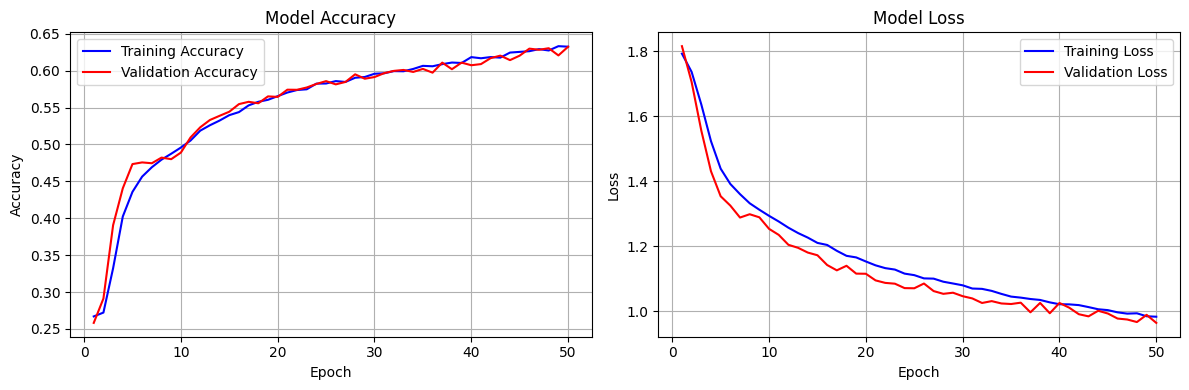


7. Evaluating model on validation set...

MODEL EVALUATION


Testing: 100%|██████████| 442/442 [00:19<00:00, 22.48it/s] 


Test Accuracy: 0.6323 (63.23%)

Detailed Classification Report:
--------------------------------------------------
              precision    recall  f1-score   support

       angry     0.5911    0.1521    0.2419       960
     disgust     0.7500    0.0270    0.0522       111
        fear     0.4156    0.3242    0.3642      1018
       happy     0.8457    0.9216    0.8820      1825
     neutral     0.6007    0.7212    0.6555      1216
         sad     0.4551    0.6760    0.5440      1139
    surprise     0.7500    0.8281    0.7871       797

    accuracy                         0.6323      7066
   macro avg     0.6297    0.5215    0.5038      7066
weighted avg     0.6317    0.6323    0.6032      7066


Confusion Matrix:
------------------------------
[[ 146    0  231   80  137  337   29]
 [  33    3   60    1    0   13    1]
 [  51    0  330   52  115  325  145]
 [   5    0    6 1682   69   30   33]
 [   0    0   32   94  877  205    8]
 [  11    1   85   32  236  770    4]
 [   1   

In [7]:
main()